# Notebook 3 - Toxic Comment Classifier from Jigsaw Data
The goal with this new dataset and classifier is to be able to classify the Dota in-game chat messages as toxic/not toxic. A hopeful addition is to identify what type of toxicity the in-game chat messages contain.

Because the Dota dataset only contains the texts and player, it is difficult to create a model to identify toxicity with this dataset alone. This is why the Jigsaw dataset of Wikipedia comments is used. It provides pre-labeled online texts based on toxicity and what type of toxicity.

## Note on scoring models
* The labels are very unbalanced. Accuracy should not be used because it will be dominated by the majority class. F-1 score should be used instead.
* Despite this, accuracy was still used in this notebook due to the simple `LogisticRegression.score()` tool for a quick result. This still helps in determining which model could be better, but it does not portray how well the model does in general.
* To better judge the final versions of the model, the results were submitted to the Kaggle competition this dataset was obtained from: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_union

import warnings
warnings.filterwarnings('ignore')

In [2]:
comments = pd.read_csv("jigsaw_train.csv")
comments['comment_text'] = comments['comment_text'].str.replace("\n", " ")

test = pd.read_csv('jigsaw_test.csv')

comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Exploratory Data Analysis

In [3]:
comments.shape

(159571, 8)

In [4]:
comments.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
for col in comments.columns:
    print("Num NA in {}: {}".format(col, sum(comments[col].isna())))

Num NA in id: 0
Num NA in comment_text: 0
Num NA in toxic: 0
Num NA in severe_toxic: 0
Num NA in obscene: 0
Num NA in threat: 0
Num NA in insult: 0
Num NA in identity_hate: 0


### Observing Labels

In [6]:
label = []
for col in comments.columns[2:]:
    print(comments.groupby(col).size(), "\n")
    label.append(comments.groupby(col).size().values[1])

toxic
0    144277
1     15294
dtype: int64 

severe_toxic
0    157976
1      1595
dtype: int64 

obscene
0    151122
1      8449
dtype: int64 

threat
0    159093
1       478
dtype: int64 

insult
0    151694
1      7877
dtype: int64 

identity_hate
0    158166
1      1405
dtype: int64 



In [7]:
label_sums = comments.iloc[:,2:].sum(axis=1)
print("{} comments are not classified as any label.".format(len(label_sums[label_sums == 0])))

143346 comments are not classified as any label.


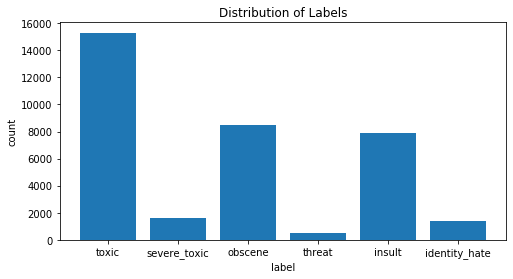

In [8]:
plt.figure(figsize=(8,4))
plt.bar(comments.columns[2:], label)
plt.xlabel("label")
plt.ylabel("count")
plt.title("Distribution of Labels");

In [9]:
print("{}% of comments are toxic in the entire dataset.".format(round(15294/159571 * 100, 2)))

9.58% of comments are toxic in the entire dataset.


In [10]:
comments[comments['comment_text'].str.contains('@')].groupby('toxic').size()

toxic
0    1051
1     111
dtype: int64

In [11]:
tmp = comments.iloc[:,2:].T
multi_label = 0
for col in tmp.columns:
    if sum(tmp[col].values) > 1:
        multi_label += 1
        
print("{} comments are labeled as more than one type of toxicity.".format(multi_label))

9865 comments are labeled as more than one type of toxicity.


In [12]:
# getting counts of comments that have a certain number of of the 6 total labels
label_counts = {}
for i in range(7):
    label_counts[i] = 0
    
for col in tmp.columns:
    num_labels = sum(tmp[col].values)
    label_counts[num_labels] += 1
    
label_counts

{0: 143346, 1: 6360, 2: 3480, 3: 4209, 4: 1760, 5: 385, 6: 31}

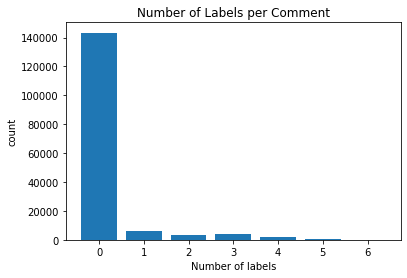

In [13]:
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Number of labels')
plt.ylabel('count')
plt.title('Number of Labels per Comment');

### Frequency of words within the entire dataset (WordCloud)

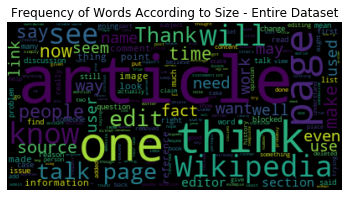

In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ""
for i in range(len(comments['comment_text'].values)):
    text += comments['comment_text'].values[i]
wordcloud = WordCloud().generate(text)

plt.title("Frequency of Words According to Size - Entire Dataset")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
from collections import Counter

text = ""
for i in range(len(comments['comment_text'].values)):
    text += comments['comment_text'].values[i]

freqs = WordCloud().process_text(text)
dict(Counter(freqs).most_common(10))

{'article': 49530,
 'one': 21916,
 'think': 17870,
 'page': 16720,
 'Wikipedia': 16474,
 'know': 16443,
 'see': 15798,
 'will': 15604,
 'talk page': 15517,
 'edit': 15141}

### Frequency of words per label (WordCloud)

Frequency of Words According to Size - toxic


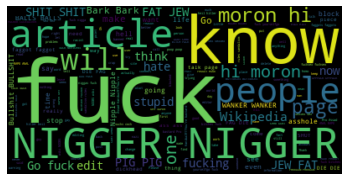

{'fuck': 3440, 'know': 2094, 'NIGGER NIGGER': 2011, 'article': 1798, 'people': 1731, 'will': 1568, 'moron hi': 1475, 'page': 1470, 'hi moron': 1468, 'one': 1427} 


Frequency of Words According to Size - severe_toxic


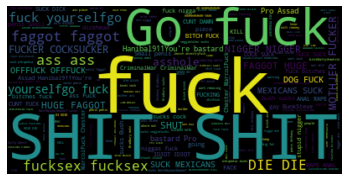

{'fuck': 1374, 'SHIT SHIT': 999, 'Go fuck': 913, 'faggot faggot': 712, 'ass ass': 677, 'DIE DIE': 632, 'fucksex fucksex': 623, 'fuck yourselfgo': 621, 'yourselfgo fuck': 619, 'asshole': 513} 


Frequency of Words According to Size - obscene


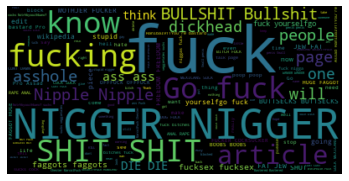

{'fuck': 2927, 'NIGGER NIGGER': 2010, 'fucking': 1199, 'SHIT SHIT': 1143, 'know': 1135, 'Go fuck': 1101, 'article': 861, 'BULLSHIT Bullshit': 829, 'asshole': 826, 'page': 784} 


Frequency of Words According to Size - threat


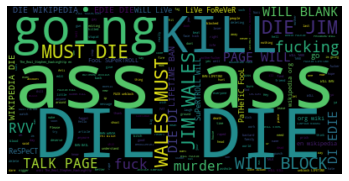

{'ass ass': 677, 'DIE DIE': 637, 'KILL': 306, 'going': 281, 'MUST DIE': 159, 'JIM WALES': 157, 'WALES MUST': 156, 'DIE JIM': 156, 'WILL BLOCK': 149, 'fucking': 137} 


Frequency of Words According to Size - insult


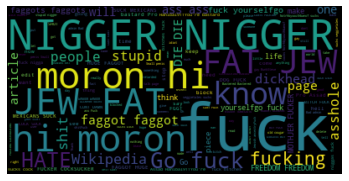

{'fuck': 2085, 'NIGGER NIGGER': 1705, 'moron hi': 1273, 'hi moron': 1266, 'JEW FAT': 1232, 'FAT JEW': 1226, 'know': 1122, 'Go fuck': 1073, 'HATE': 1011, 'fucking': 948} 


Frequency of Words According to Size - identity_hate


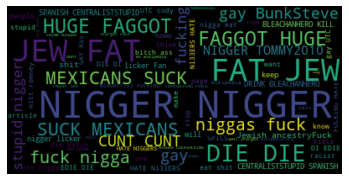

{'NIGGER NIGGER': 1896, 'JEW FAT': 1232, 'FAT JEW': 1225, 'DIE DIE': 634, 'HUGE FAGGOT': 416, 'FAGGOT HUGE': 416, 'SUCK MEXICANS': 355, 'MEXICANS SUCK': 355, 'fuck nigga': 336, 'niggas fuck': 332} 




In [16]:
for col in comments.columns[2:]:
    text = ""
    for i in range(len(comments[comments[col]==1]['comment_text'].values)):
        text += comments[comments[col]==1]['comment_text'].values[i]
    wordcloud = WordCloud().generate(text)
    
    print("Frequency of Words According to Size -", col)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    freqs = WordCloud().process_text(text)
    print(dict(Counter(freqs).most_common(10)), "\n\n")

Why are some racial slurs repeated as bigrams? Why are some bigrams reversed? The subset below shows that they were spammed.

In [17]:
comments[comments['comment_text'].str.contains('NIGGER NIGGER')]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
13352,2347a52d875dece2,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG...,1,0,1,0,1,1
15409,28b59eb138ae6e1f,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG...,1,0,1,0,0,1
41888,6fc049a35193e216,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG...,1,1,1,0,1,1
77202,cec85028506a5417,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG...,1,0,1,0,1,1
86940,e8876597276c3b32,YOU LIKE COCK 8==========D - - - - - NIGGER ...,1,0,1,0,1,0


_____

# Model 1 - Logistic Regression with only Tfidf (analyzer='word')

In [18]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(comments[['comment_text']], comments.iloc[:,2:], random_state=42)

### Train

Applying the model on one label before applying it to all of the labels.

In [19]:
X_train['comment_text'] = X_train['comment_text'].str.replace(r"[(\.),(\|)!:='&(\")]", "")
X_train.head()

,comment_text
75144,I have added the newline sign back in you ca...
154769,Dont worry I think I fixed it But still looks ...
48346,Well it seems to me that you have a problem w...
72576,Contents The contents box just appears when th...
79974,Btw did you know the article links to a sit...


In [20]:
# Applying Tfidf
vectorizer = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word', 
                             stop_words= 'english', ngram_range=(1,3), dtype=np.float32)
vectored_X_train = vectorizer.fit_transform(X_train['comment_text'])

# Using a logistic regression classifier
lr = LogisticRegression(random_state=42, solver='lbfgs').fit(vectored_X_train, Y_train.iloc[:,0])

training_accuracy = lr.score(vectored_X_train, Y_train.iloc[:,0])
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9593241865672889


In [21]:
# applying the model to all labels: toxic, severe_toxic, obscene, threat, insult, identity_hate
labels = list(Y_train.columns)
for i in range(len(labels)):
    lr = LogisticRegression(random_state=42, solver='lbfgs').fit(vectored_X_train, Y_train.iloc[:,i])
    training_accuracy = lr.score(vectored_X_train, Y_train.iloc[:,i])
    print("Training Accuracy for label {}: ".format(labels[i]), training_accuracy)

Training Accuracy for label toxic:  0.9593241865672889
Training Accuracy for label severe_toxic:  0.9907585354033323
Training Accuracy for label obscene:  0.9795868914921707
Training Accuracy for label threat:  0.9970671301325222
Training Accuracy for label insult:  0.9731362489346412
Training Accuracy for label identity_hate:  0.9924547535887966


### Test

In [22]:
vectored_X_test = vectorizer.fit_transform(X_test['comment_text'])
test_accuracy = lr.score(vectored_X_test, Y_test.iloc[:,0])
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.9043691875767679


In [23]:
for i in range(len(labels)):
    test_accuracy = lr.score(vectored_X_test, Y_test.iloc[:,i])
    print("Test Accuracy for label {}: ".format(labels[i]), test_accuracy)

Test Accuracy for label toxic:  0.9043691875767679
Test Accuracy for label severe_toxic:  0.989822775925601
Test Accuracy for label obscene:  0.9462813024841451
Test Accuracy for label threat:  0.9973679592911037
Test Accuracy for label insult:  0.9495901536610433
Test Accuracy for label identity_hate:  0.9910510615897525


* Reminder of the note displayed at the beginning of this notebook: accuracy is not suitable here because this dataset has dominating classes. Accuracy is used due to the simple `lr.score()` tool and to compare different models, but it does not tell how well this model does.

_______

# Model 2 - Logistic Regression with Tfidf (analyzer='word') and Features
* **Features:** length of text, proportion of capital letters, number of offensive words, contains specific offensive words

### Length of Text

In [24]:
comments_copy = comments.copy()
comments_copy['len'] = comments_copy['comment_text'].apply(len) - comments_copy['comment_text'].str.count(" ")

In [25]:
for col in comments_copy.columns[2:8]:
    print(comments_copy.groupby(col)['len'].mean(), "\n")

toxic
0    333.430075
1    242.193148
Name: len, dtype: float64 

severe_toxic
0    324.180338
1    374.721003
Name: len, dtype: float64 

obscene
0    329.665403
1    235.613445
Name: len, dtype: float64 

threat
0    324.906684
1    251.075314
Name: len, dtype: float64 

insult
0    329.727201
1    227.593627
Name: len, dtype: float64 

identity_hate
0    325.306128
1    254.821352
Name: len, dtype: float64 



Overall, hateful comments tend to be shorter by about 80-100 characters than clean comments, except for the severe_toxic category.

### Number of Capital Letters

In [26]:
def num_upper(text):
    """Returns the number of capital letters in a string."""
    num = 0
    for i in text:
        if i.isupper():
            num += 1
    return num

comments_copy['caps'] = comments_copy['comment_text'].apply(num_upper)

for col in comments_copy.columns[2:8]:
    print(comments_copy.groupby(col)['caps'].mean(), "\n")

toxic
0    14.294198
1    44.190859
Name: caps, dtype: float64 

severe_toxic
0     15.768661
1    154.927273
Name: caps, dtype: float64 

obscene
0    15.295126
1    50.508818
Name: caps, dtype: float64 

threat
0    16.981948
1    76.297071
Name: caps, dtype: float64 

insult
0    15.489129
1    49.329821
Name: caps, dtype: float64 

identity_hate
0    16.672205
1    72.030605
Name: caps, dtype: float64 



There seems to be a large difference between the number of capital letters between clean and non-clean messages, but looking at proportions would be more suitable due to various text lengths.

### Proportion of Capital Letters

In [27]:
comments_copy['proportion of caps'] = comments_copy['caps'] / comments_copy['len']

for col in comments_copy.columns[2:8]:
    print(comments_copy.groupby(col)['proportion of caps'].mean(), "\n")

toxic
0    0.054293
1    0.140094
Name: proportion of caps, dtype: float64 

severe_toxic
0    0.060577
1    0.254636
Name: proportion of caps, dtype: float64 

obscene
0    0.057580
1    0.150819
Name: proportion of caps, dtype: float64 

threat
0    0.062163
1    0.180303
Name: proportion of caps, dtype: float64 

insult
0    0.058079
1    0.147976
Name: proportion of caps, dtype: float64 

identity_hate
0    0.061523
1    0.174427
Name: proportion of caps, dtype: float64 



There is still a notable difference, and proportion of capital letters will be used instead of number of capital letters.

### Use of Offensive Language

A list of 1,300+ English terms that could be found offensive will be used in this next feature. "The list contains some words that many people won't find offensive, but it's a good start for anybody wanting to block offensive or profane terms on their Site."
* From Luis von Ahn's Research Group: _https://www.cs.cmu.edu/~biglou/resources/bad-words.txt_

In [28]:
bad_words = pd.read_fwf("bad-words.txt", header=None).iloc[:,0].values
print("Number of offensive words considered:", len(bad_words))
bad_words[:30]

Number of offensive words considered: 1383


array(['abbo', 'abo', 'abortion', 'abuse', 'addict', 'addicts', 'adult',
       'africa', 'african', 'alla', 'allah', 'alligatorbait', 'amateur',
       'american', 'anal', 'analannie', 'analsex', 'angie', 'angry',
       'anus', 'arab', 'arabs', 'areola', 'argie', 'aroused', 'arse',
       'arsehole', 'asian', 'ass', 'assassin'], dtype=object)

In [29]:
# identifying offensive words and quantities
def offensive_word(text):
    """Returns the number of offensive words in a string."""
    return [word.lower() for word in text.split(" ") if word.lower() in bad_words]

comments_copy['offensive word'] = comments_copy['comment_text'].apply(offensive_word)
comments_copy['num offensive words'] = comments_copy['offensive word'].apply(len)
comments_copy.sort_values('num offensive words')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,len,caps,proportion of caps,offensive word,num offensive words
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,222,17,0.076577,[],0
99459,140fa4d86f105ecd,Linkspam? Is that what's causing the formattin...,0,0,0,0,0,0,76,2,0.026316,[],0
99457,140cb8dc1570e423,I noticed it doesn't mention if the real Presi...,0,0,0,0,0,0,57,2,0.035088,[],0
99456,140b6979e9d7bcec,"I already noticed the network, thanks anyway:)...",0,0,0,0,0,0,82,2,0.024390,[],0
99452,1407012dc36d1689,Thanks I would have used the ping thanks but i...,0,0,0,0,0,0,124,5,0.040323,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8705,171ebb2b785f72bd,BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL...,1,0,0,0,0,0,4167,4167,1.000000,"[balls, balls, balls, balls, balls, balls, bal...",833
87454,e9f7aeb9490f44a6,SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT SHIT S...,1,1,1,0,0,0,4000,4000,1.000000,"[shit, shit, shit, shit, shit, shit, shit, shi...",1000
32400,56311e1c0b2cbb52,THAT WAS REALLY MILLESECONDS WASNT IT BITCH ...,1,0,1,0,1,1,3742,3742,1.000000,"[bitch, fat, jew, fat, jew, fat, jew, fat, jew...",1228
153353,9bb20c51c9fec236,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JE...,1,0,0,0,1,1,3753,3753,1.000000,"[fat, jew, fat, jew, fat, jew, fat, jew, fat, ...",1243


In [30]:
comments_copy.groupby('toxic').mean()

,severe_toxic,obscene,threat,insult,identity_hate,len,caps,proportion of caps,num offensive words
toxic,,,,,,,,,
0,0.000000,0.003625,0.000201,0.003694,0.000714,333.430075,14.294198,0.054293,0.364611
1,0.104289,0.518242,0.029358,0.480188,0.085131,242.193148,44.190859,0.140094,4.042043


Some rows have hundreds of offensive words within one message. This is a sign of spam and possibly an indicator of harrassment.

In [31]:
print("Average number of offensive words used in non-toxic messages:", 
      round(comments_copy[comments_copy['toxic']==0]['num offensive words'].mean(), 3))

Average number of offensive words used in non-toxic messages: 0.365


In [32]:
print("Average number of offensive words used in toxic messages:", 
     round(comments_copy[comments_copy['toxic']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in toxic messages: 4.042


In [33]:
print("Average number of offensive words used in severely toxic messages:", 
      round(comments_copy[comments_copy['severe_toxic']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in severely toxic messages: 16.014


In [34]:
print("Average number of offensive words used in obscene messages:", 
      round(comments_copy[comments_copy['obscene']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in obscene messages: 5.314


In [35]:
print("Average number of offensive words used in threatening messages:", 
      round(comments_copy[comments_copy['threat']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in threatening messages: 5.916


In [36]:
print("Average number of offensive words used in insulting messages:", 
      round(comments_copy[comments_copy['insult']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in insulting messages: 5.13


In [37]:
print("Average number of offensive words used in identity hate messages:", 
      round(comments_copy[comments_copy['identity_hate']==1]['num offensive words'].mean(), 3))

Average number of offensive words used in identity hate messages: 10.012


There is a large difference between toxic and non-toxic messages in the number of offensive words used. There are also large variations in the number of offensive words used between the different labels. Severely toxic messages contain the highest amount of offensive words, followed by identity hate messages. Obscene, threatening, and insulting messages contain nearly the same amount of offensive words.

### Containment of Offensive Words
* Which offensive words were used the most within each label? 
* Are there offensive words used in a category but not the others?

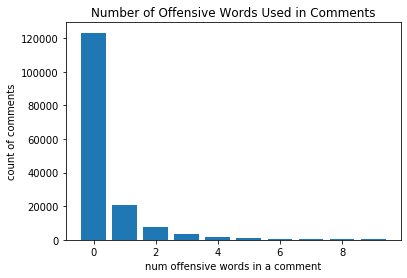

In [38]:
num_offense_words = comments_copy.groupby('num offensive words').size().head(10)
plt.bar(num_offense_words.index, num_offense_words.values)
plt.xlabel('num offensive words in a comment')
plt.ylabel('count of comments')
plt.title('Number of Offensive Words Used in Comments');

In [39]:
has_offense_words = comments_copy[comments_copy['num offensive words'] > 0]

# Looking at which offensive words are used in non-toxic comments (used casually, not offensively)
non_toxic_offense = has_offense_words[has_offense_words['toxic']==0]['offensive word'].values
words = []
for array in non_toxic_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used Casually (used in non-toxic comments)")
non_toxic = pd.Series(words).value_counts().head(20)
non_toxic

'Offensive Words' Used Casually (used in non-toxic comments)


american     2100
attack       1620
faith        1343
german       1170
black        1059
god          1054
jewish        922
death         904
church        891
christian     802
abuse         789
uk            764
ethnic        711
period        706
european      648
chinese       624
japanese      604
dead          598
failed        585
fight         580
dtype: int64

In [40]:
toxic_offense = has_offense_words[has_offense_words['toxic']==1]['offensive word'].values
words = []
for array in toxic_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Toxic Comments")
toxic = pd.Series(words).value_counts().head(15)
toxic

'Offensive Words' Used in Toxic Comments


fuck       8325
nigger     3223
fucking    3165
suck       2872
shit       2684
fat        1937
die        1803
gay        1774
faggot     1741
moron      1695
ass        1606
jew        1294
stupid     1216
cunt       1039
dick        999
dtype: int64

In [41]:
severe_toxic_offense = has_offense_words[has_offense_words['severe_toxic']==1]['offensive word'].values
words = []
for array in severe_toxic_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Severely Toxic Comments")
severe_toxic = pd.Series(words).value_counts().head(15)
severe_toxic

'Offensive Words' Used in Severely Toxic Comments


fuck       5992
suck       2269
shit       1681
faggot     1509
fucking    1372
ass        1103
nigger      999
die         972
cock        639
kill        577
cunt        576
fucker      551
bitch       492
dick        459
bastard     432
dtype: int64

In [42]:
obscene_offense = has_offense_words[has_offense_words['obscene']==1]['offensive word'].values
words = []
for array in obscene_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Obscene Comments")
obscene = pd.Series(words).value_counts().head(15)
obscene

'Offensive Words' Used in Obscene Comments


fuck        8255
fucking     3066
suck        2684
nigger      2669
shit        2537
ass         1557
fat         1260
die         1089
cunt        1028
bullshit     973
faggot       972
dick         965
bitch        877
stupid       856
nipple       823
dtype: int64

In [43]:
threat_offense = has_offense_words[has_offense_words['threat']==1]['offensive word'].values
words = []
for array in threat_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Threatening Comments")
threat = pd.Series(words).value_counts().head(15)
threat

'Offensive Words' Used in Threatening Comments


die        960
kill       501
fucking    136
fuck       124
murder     107
fuckin      99
ass         72
bitch       44
shit        42
rape        42
hell        33
fat         31
death       29
stupid      28
shoot       22
dtype: int64

In [44]:
insult_offense = has_offense_words[has_offense_words['insult']==1]['offensive word'].values
words = []
for array in insult_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Insulting Comments")
insult = pd.Series(words).value_counts().head(15)
insult

'Offensive Words' Used in Insulting Comments


fuck       6452
nigger     2721
fucking    2696
suck       2474
fat        1901
faggot     1618
moron      1330
jew        1272
die        1146
shit       1130
ass         994
cunt        976
stupid      931
bitch       840
dick        796
dtype: int64

In [45]:
identity_hate_offense = has_offense_words[has_offense_words['identity_hate']==1]['offensive word'].values
words = []
for array in identity_hate_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used in Identity Hate Comments")
identity_hate = pd.Series(words).value_counts().head(15)
identity_hate

'Offensive Words' Used in Identity Hate Comments


nigger     2912
fat        1316
jew        1284
die         859
fuck        852
faggot      606
gay         540
fucking     516
suck        421
stupid      388
cunt        365
ass         337
shit        315
bitch       261
kill        193
dtype: int64

It looks like the top used "offensive" words within the non-toxic messages are not within the top words of positively labeled messages. Let's double check.

In [46]:
# Finding the words used in non-toxic messages AND in positively labeled messages
used_words = toxic, severe_toxic, obscene, threat, insult, identity_hate
label = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(len(used_words)):
    overlap = []
    for word in non_toxic.index:
        if word in used_words[i].index:
            overlap.append(word)
    print(label[i], overlap)

toxic []
severe_toxic []
obscene []
threat ['death']
insult []
identity_hate []


Among the top "offensive" words people used in non-toxic messages, only the word "death" was common among the top offensive words of other categories. "Death" was also top among the 'threat' category.

In [47]:
display(non_toxic, threat)

american     2100
attack       1620
faith        1343
german       1170
black        1059
god          1054
jewish        922
death         904
church        891
christian     802
abuse         789
uk            764
ethnic        711
period        706
european      648
chinese       624
japanese      604
dead          598
failed        585
fight         580
dtype: int64

die        960
kill       501
fucking    136
fuck       124
murder     107
fuckin      99
ass         72
bitch       44
shit        42
rape        42
hell        33
fat         31
death       29
stupid      28
shoot       22
dtype: int64

'death' is used about 900 times in the non-toxic subset of this dataset and used 29 times in the threat subset of this dataset. Given how few times it was used in the threat subset, especially compared to the amounts of the other offensive words used in this subset, it is safe to take 'death' out of the offensive words list. 'death' was the only word used in both the non-toxic and labeled comments. The other top 'offensive words' used in the non-toxic subset can be taken out of the offensive words list.

In [48]:
# Removing the top offensive words used in non-toxic messages from the list of words to consider offensive
words_to_remove = non_toxic.index
updated_bad_words = [word for word in bad_words if word not in words_to_remove]
len(updated_bad_words)

1363

In [49]:
def updated_offensive_word(text):
    """Returns the number of offensive words in a string."""
    return [word.lower() for word in text.split(" ") if word.lower() in updated_bad_words]

comments_copy['offensive word'] = comments_copy['comment_text'].apply(updated_offensive_word)
comments_copy['num offensive words'] = comments_copy['offensive word'].apply(len)

In [50]:
# Checking the top "offensive" words in non-toxic comments after removing some words from the list
has_offense_words = comments_copy[comments_copy['num offensive words'] > 0]

non_toxic_offense = has_offense_words[has_offense_words['toxic']==0]['offensive word'].values
words = []
for array in non_toxic_offense:
    for item in array:
        words.append(item)

print("'Offensive Words' Used Casually (used in non-toxic comments)")
non_toxic = pd.Series(words).value_counts().head(20)
non_toxic

'Offensive Words' Used Casually (used in non-toxic comments)


israel        564
propaganda    542
jesus         540
killed        539
soviet        526
catholic      525
lies          501
african       500
muslim        494
died          472
stupid        459
remains       444
hell          432
nazi          427
minority      424
conspiracy    405
israeli       391
racist        389
sexual        383
canadian      382
dtype: int64

In [51]:
used_words = toxic, severe_toxic, obscene, threat, insult, identity_hate
label = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

for i in range(len(used_words)):
    overlap = []
    for word in non_toxic.index:
        if word in used_words[i].index:
            overlap.append(word)
    print(label[i], overlap)

toxic ['stupid']
severe_toxic []
obscene ['stupid']
threat ['stupid', 'hell']
insult ['stupid']
identity_hate ['stupid']


Using the same logic as before, offensive words used in non-toxic comments can be removed except "stupid" and "hell".

In [52]:
# Removing top offensive words of non-toxic comments that do not overlap
words_to_remove = [word for word in list(non_toxic.index) if word not in ['stupid', 'hell']]
updated_bad_words = [word for word in updated_bad_words if word not in words_to_remove]
len(updated_bad_words)

1345

In [53]:
comments_copy['offensive word'] = comments_copy['comment_text'].apply(updated_offensive_word)
comments_copy['num offensive words'] = comments_copy['offensive word'].apply(len)

So far, around 40 of the most used 'offensive words' in non-toxic comments have been removed from the bad_words list because these words were not commonly used in actually offensive/toxic messages.

In [54]:
all_offense = []
for series in used_words:
    for word in series.index:
        all_offense.append(word)

offense_word_counts = pd.Series(all_offense).value_counts()
unique_offense = offense_word_counts[offense_word_counts == 1]
unique_offense

fuckin      1
bullshit    1
nipple      1
murder      1
cock        1
death       1
fucker      1
rape        1
hell        1
shoot       1
bastard     1
dtype: int64

Above is a list of words that are commonly used in one label but not commonly in any other. They are popular words for that label and not for the other labels. Although they are popular within one category, they are still used in other categories, just not as frequently. Let's see which labels they are associated with.

In [55]:
for i in range(len(used_words)):
    for word in used_words[i].index:
        if word in unique_offense.index:
            print("Label: {} | Unique common word: {} | Count: {}".format(label[i], word, used_words[i].loc[word]))

Label: severe_toxic | Unique common word: cock | Count: 639
Label: severe_toxic | Unique common word: fucker | Count: 551
Label: severe_toxic | Unique common word: bastard | Count: 432
Label: obscene | Unique common word: bullshit | Count: 973
Label: obscene | Unique common word: nipple | Count: 823
Label: threat | Unique common word: murder | Count: 107
Label: threat | Unique common word: fuckin | Count: 99
Label: threat | Unique common word: rape | Count: 42
Label: threat | Unique common word: hell | Count: 33
Label: threat | Unique common word: death | Count: 29
Label: threat | Unique common word: shoot | Count: 22


There will be features made for the unique offensive words within the hundreds to try out.

In [56]:
comments_copy["contains 'cock'"] = comments_copy['comment_text'].str.lower().str.contains('cock')
comments_copy["contains 'cock'"] = comments_copy["contains 'cock'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'fucker'"] = comments_copy['comment_text'].str.lower().str.contains('fucker')
comments_copy["contains 'fucker'"] = comments_copy["contains 'fucker'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'bastard'"] = comments_copy['comment_text'].str.lower().str.contains('bastard')
comments_copy["contains 'bastard'"] = comments_copy["contains 'bastard'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'bullshit'"] = comments_copy['comment_text'].str.lower().str.contains('bullshit')
comments_copy["contains 'bullshit'"] = comments_copy["contains 'bullshit'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'nipple'"] = comments_copy['comment_text'].str.lower().str.contains('nipple')
comments_copy["contains 'nipple'"] = comments_copy["contains 'nipple'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'murder'"] = comments_copy['comment_text'].str.lower().str.contains('murder')
comments_copy["contains 'murder'"] = comments_copy["contains 'murder'"].replace(False, 0).replace(True, 1).apply(int)

'rape' and 'shoot' also sound very unique to threats despite the low counts, so they will also be included.

In [57]:
comments_copy["contains 'rape'"] = comments_copy['comment_text'].str.lower().str.contains('rape')
comments_copy["contains 'rape'"] = comments_copy["contains 'rape'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy["contains 'shoot'"] = comments_copy['comment_text'].str.lower().str.contains('shoot')
comments_copy["contains 'shoot'"] = comments_copy["contains 'shoot'"].replace(False, 0).replace(True, 1).apply(int)

comments_copy.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,len,caps,...,offensive word,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,222,17,...,[],0,0,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,95,8,...,[],0,0,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,192,4,...,[],0,0,0,0,0,0,0,0,0


In [58]:
# dropping columns that won't be used for the input
comments_copy = comments_copy.drop(['caps', 'offensive word', 'toxic', 'severe_toxic', 'id',
                                    'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
comments_copy.head(3)

,comment_text,len,proportion of caps,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,Explanation Why the edits made under my userna...,222,0.076577,0,0,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,95,0.084211,0,0,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",192,0.020833,0,0,0,0,0,0,0,0,0


### Applying the New Features w/ Tfidf

### Train

In [59]:
# Normalizing len
len_min = comments_copy['len'].min()
len_max = comments_copy['len'].max()
comments_copy['len'] = (comments_copy['len'].values - len_min) / (len_max - len_min)

In [60]:
comments_copy['comment_text'] = comments_copy['comment_text'].str.replace(r"[(\.),(\|)!:='&(\")]", "")
X_train, X_test, Y_train, Y_test = train_test_split(comments_copy, comments.iloc[:,2:], random_state=42)

X_train.head(3)

,comment_text,len,proportion of caps,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
75144,I have added the newline sign back in you ca...,0.064919,0.030581,0,0,0,0,0,0,0,0,0
154769,Dont worry I think I fixed it But still looks ...,0.008871,0.081633,0,0,0,0,0,0,0,0,0
48346,Well it seems to me that you have a problem w...,0.077016,0.038760,0,0,0,0,0,0,0,0,0


Applying the model on one label before applying it to all.

In [62]:
from scipy.sparse import hstack

# Using Tfidf (analyzer='word')
vectorizer = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word', 
                             stop_words= 'english', ngram_range=(1,3), dtype=np.float32)
vectored_X_train = vectorizer.fit_transform(X_train['comment_text'])

final_X_train = hstack([vectored_X_train, X_train.iloc[:,1:]])

In [63]:
# Training a logistic regression classifier
lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_X_train, Y_train.iloc[:,0])

training_accuracy = lr.score(final_X_train, Y_train.iloc[:,0])
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9601764735373252


Applying the model to all labels: toxic, severe_toxic, obscene, threat, insult, identity_hate

In [64]:
labels = list(Y_train.columns)
for i in range(len(labels)):
    lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_X_train, Y_train.iloc[:,i])
    training_accuracy = lr.score(final_X_train, Y_train.iloc[:,i])
    print("Training Accuracy for label {}: ".format(labels[i]), training_accuracy)

Training Accuracy for label toxic:  0.9601764735373252
Training Accuracy for label severe_toxic:  0.9907251123848995
Training Accuracy for label obscene:  0.979261017062451
Training Accuracy for label threat:  0.9970838416417387
Training Accuracy for label insult:  0.9724176540383362
Training Accuracy for label identity_hate:  0.9922876384966326


### Test

In [65]:
vectored_X_test = vectorizer.fit_transform(X_test['comment_text'])
final_X_test = hstack([vectored_X_test, X_test.iloc[:,1:]])

test_accuracy = lr.score(final_X_test, Y_test.iloc[:,0])
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.904319053468027


In [66]:
for i in range(len(labels)):
    test_accuracy = lr.score(final_X_test, Y_test.iloc[:,i])
    print("Test Accuracy for label {}: ".format(labels[i]), test_accuracy)

Test Accuracy for label toxic:  0.904319053468027
Test Accuracy for label severe_toxic:  0.9897726418168601
Test Accuracy for label obscene:  0.9462311683754042
Test Accuracy for label threat:  0.9973178251823628
Test Accuracy for label insult:  0.9495400195523024
Test Accuracy for label identity_hate:  0.9910009274810117


_____

# Model 3 - Using Tfidf 'char' in Addition to Tfidf 'word' and Features

In [67]:
# Tfidf analyzer='word'
word_vectorizer = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word', 
                             stop_words= 'english', ngram_range=(1,3), dtype=np.float32)
word_X_train = word_vectorizer.fit_transform(X_train['comment_text'])

# Tfidf analyzer='char'
char_vectorizer = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char', 
                             stop_words= 'english', ngram_range=(2,5), dtype=np.float32)
char_X_train = char_vectorizer.fit_transform(X_train['comment_text'])

# Combining all features
word_and_char = hstack([char_X_train, word_X_train])
final_X_train = hstack([word_and_char, X_train.iloc[:,1:]])

In [68]:
lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_X_train, Y_train.iloc[:,0])

training_accuracy = lr.score(final_X_train, Y_train.iloc[:,0])
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.9692758903056535


In [69]:
labels = list(Y_train.columns)
for i in range(len(labels)):
    lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_X_train, Y_train.iloc[:,i])
    training_accuracy = lr.score(final_X_train, Y_train.iloc[:,i])
    print("Training Accuracy for label {}: ".format(labels[i]), training_accuracy)

Training Accuracy for label toxic:  0.9692758903056535
Training Accuracy for label severe_toxic:  0.9915606878457194
Training Accuracy for label obscene:  0.9814836477882317
Training Accuracy for label threat:  0.9976520329550962
Training Accuracy for label insult:  0.9761276090843765
Training Accuracy for label identity_hate:  0.9934574441417805


Generally a slight improvement on all labels except the 'toxic' label.

In [70]:
word_X_test = word_vectorizer.fit_transform(X_test['comment_text'])
char_X_test = char_vectorizer.fit_transform(X_test['comment_text'])

word_and_char_test = hstack([char_X_test, word_X_test])
final_X_test = hstack([word_and_char_test, X_test.iloc[:,1:]])

test_accuracy = lr.score(final_X_test, Y_test.iloc[:,0])
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.9043691875767679


In [71]:
for i in range(len(labels)):
    test_accuracy = lr.score(final_X_test, Y_test.iloc[:,i])
    print("Test Accuracy for label {}: ".format(labels[i]), test_accuracy)

Test Accuracy for label toxic:  0.9043691875767679
Test Accuracy for label severe_toxic:  0.989822775925601
Test Accuracy for label obscene:  0.9462813024841451
Test Accuracy for label threat:  0.9973679592911037
Test Accuracy for label insult:  0.9495901536610433
Test Accuracy for label identity_hate:  0.9910510615897525


Generally no improvement for the test accuracy.

_____

# Summary

**Model 1 - Tfidf word only**
* Training Accuracy for label toxic:  0.9593241865672889
* Training Accuracy for label severe_toxic:  0.9907585354033323
* Training Accuracy for label obscene:  0.9795868914921707
* Training Accuracy for label threat:  0.9970671301325222
* Training Accuracy for label insult:  0.9731362489346412
* Training Accuracy for label identity_hate:  0.9924547535887966

**Model 2 - Tfidf word with features**
* Training Accuracy for label toxic:  0.9601764735373252
* Training Accuracy for label severe_toxic:  0.9907251123848995
* Training Accuracy for label obscene:  0.979261017062451
* Training Accuracy for label threat:  0.9970838416417387
* Training Accuracy for label insult:  0.9724176540383362
* Training Accuracy for label identity_hate:  0.9922876384966326

**Model 3 - Tfidf word, Tfidf char, and features**
* Training Accuracy for label toxic:  0.9692758903056535
* Training Accuracy for label severe_toxic:  0.9915606878457194
* Training Accuracy for label obscene:  0.9814836477882317
* Training Accuracy for label threat:  0.9976520329550962
* Training Accuracy for label insult:  0.9761276090843765
* Training Accuracy for label identity_hate:  0.9934574441417805

# Section Conclusion

With additional features to Tfidf 'word' [Model 2], the train accuracies improved from [Model 1], though only slightly. With Tfidf analyzer='char' on top of Tfidf analyzer='word' and the features [Model 3], the accuracy slightly increased again. [Model 3] worked the best on the train set.

____

# Submission
* Note: For the Kaggle submission, probabilities of labels are submitted, not the predicted labels themselves.

## Model 3 will be used for the first submission.

In [72]:
# SUBMISSION (applying model to test.csv)
testing = test.copy()

# Cleaning strings
testing['comment_text'] = testing['comment_text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
testing['comment_text'] = testing['comment_text'].str.replace("\n", "")

# Getting length
testing['len'] = testing['comment_text'].apply(len) - testing['comment_text'].str.count(" ")
len_min = testing['len'].min()
len_max = testing['len'].max()
testing['len'] = (testing['len'].values - len_min) / (len_max - len_min)

# Getting proportion of caps
testing['caps'] = testing['comment_text'].apply(num_upper)
testing['proportion of caps'] = testing['caps'] / testing['len']

# Getting number of offensive words
testing['offensive word'] = testing['comment_text'].apply(updated_offensive_word)
testing['num offensive words'] = testing['offensive word'].apply(len)

# Getting containment of specific offensive words
testing["contains 'cock'"] = testing['comment_text'].str.lower().str.contains('cock')
testing["contains 'cock'"] = testing["contains 'cock'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'fucker'"] = testing['comment_text'].str.lower().str.contains('fucker')
testing["contains 'fucker'"] = testing["contains 'fucker'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'bastard'"] = testing['comment_text'].str.lower().str.contains('bastard')
testing["contains 'bastard'"] = testing["contains 'bastard'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'bullshit'"] = testing['comment_text'].str.lower().str.contains('bullshit')
testing["contains 'bullshit'"] = testing["contains 'bullshit'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'nipple'"] = testing['comment_text'].str.lower().str.contains('nipple')
testing["contains 'nipple'"] = testing["contains 'nipple'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'murder'"] = testing['comment_text'].str.lower().str.contains('murder')
testing["contains 'murder'"] = testing["contains 'murder'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'rape'"] = testing['comment_text'].str.lower().str.contains('rape')
testing["contains 'rape'"] = testing["contains 'rape'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'shoot'"] = testing['comment_text'].str.lower().str.contains('shoot')
testing["contains 'shoot'"] = testing["contains 'shoot'"].replace(False, 0).replace(True, 1).apply(int)

testing.head(3)

,id,comment_text,len,caps,proportion of caps,offensive word,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...,0.056914,4,0.014085,"[bitch, bitch, ass, shit]",4,0,0,0,0,0,0,0,0
1,0000247867823ef7,From RfC The title is fine as it is IMO,0.006012,7,0.233333,[],0,0,0,0,0,0,0,0,0
2,00013b17ad220c46,Sources Zawe Ashton on Lapland — /,0.005611,4,0.142857,[],0,0,0,0,0,0,0,0,0


In [73]:
# When len=0 (comment_text is empty), proportion of caps is 0 - Accounting for division by 0, which gives NA
testing['proportion of caps'] = testing['proportion of caps'].fillna(0)
testing = testing.drop(['id', 'caps', 'offensive word'], axis=1)
testing.head(3)

,comment_text,len,proportion of caps,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,Yo bitch Ja Rule is more succesful then youll ...,0.056914,0.014085,4,0,0,0,0,0,0,0,0
1,From RfC The title is fine as it is IMO,0.006012,0.233333,0,0,0,0,0,0,0,0,0
2,Sources Zawe Ashton on Lapland — /,0.005611,0.142857,0,0,0,0,0,0,0,0,0


In [74]:
# Tfidf analyzer='word'
word_vectorizer = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word', 
                             stop_words= 'english', ngram_range=(1,3), dtype=np.float32)
word_testing = word_vectorizer.fit_transform(testing['comment_text'])

# Tfidf analyzer='char'
char_vectorizer = TfidfVectorizer(max_features=30000, lowercase=True, analyzer='char', 
                             stop_words= 'english', ngram_range=(2,5), dtype=np.float32)
char_testing = char_vectorizer.fit_transform(testing['comment_text'])

# Combining all features
word_and_char = hstack([char_testing, word_testing])
final_testing = hstack([word_and_char, testing.iloc[:,1:]])

In [75]:
results = {}
for i in range(len(labels)):
    lr = LogisticRegression(random_state=42, solver='lbfgs').fit(final_X_train, Y_train.iloc[:,i])
    results[labels[i]] = lr.predict_proba(final_testing)[:,1]

In [77]:
submission = pd.DataFrame({'id': test['id']})
submission['toxic'] = results['toxic']
submission['severe_toxic'] = results['severe_toxic']
submission['obscene'] = results['obscene']
submission['threat'] = results['threat']
submission['insult'] = results['insult']
submission['identity_hate'] = results['identity_hate']
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.077568,0.005814,0.025874,0.002086,0.018496,0.005608
1,0000247867823ef7,0.025722,0.005526,0.019768,0.002060,0.009690,0.004742
2,00013b17ad220c46,0.046006,0.004934,0.013775,0.001404,0.008413,0.003110
3,00017563c3f7919a,0.029407,0.003708,0.015723,0.001257,0.012490,0.003266
4,00017695ad8997eb,0.041622,0.003538,0.020288,0.001588,0.013522,0.003676
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.011509,0.002785,0.012354,0.001432,0.006537,0.002650
153160,fffd7a9a6eb32c16,0.049840,0.004101,0.025078,0.001406,0.015538,0.004058
153161,fffda9e8d6fafa9e,0.017827,0.004324,0.013419,0.001715,0.007631,0.003724
153162,fffe8f1340a79fc2,0.072815,0.005065,0.024154,0.001917,0.019788,0.006898


In [78]:
# submission.to_csv('submission.csv', index=False)

### This model received a score of .77. Further testing will be done below.

_____

## Model 3 but with Different Tfidf Hyperparameters

In [109]:
# SUBMISSION (applying model to test.csv)
testing = test.copy()

# Cleaning strings
testing['comment_text'] = testing['comment_text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
testing['comment_text'] = testing['comment_text'].str.replace("\n", "")

# Getting length
testing['len'] = testing['comment_text'].apply(len) - testing['comment_text'].str.count(" ")
len_min = testing['len'].min()
len_max = testing['len'].max()
testing['len'] = (testing['len'].values - len_min) / (len_max - len_min)

# Getting proportion of caps
testing['caps'] = testing['comment_text'].apply(num_upper)
testing['proportion of caps'] = testing['caps'] / testing['len']

# Getting number of offensive words
testing['offensive word'] = testing['comment_text'].apply(updated_offensive_word)
testing['num offensive words'] = testing['offensive word'].apply(len)

# Containment of specific offensive word
testing["contains 'cock'"] = testing['comment_text'].str.lower().str.contains('cock')
testing["contains 'cock'"] = testing["contains 'cock'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'fucker'"] = testing['comment_text'].str.lower().str.contains('fucker')
testing["contains 'fucker'"] = testing["contains 'fucker'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'bastard'"] = testing['comment_text'].str.lower().str.contains('bastard')
testing["contains 'bastard'"] = testing["contains 'bastard'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'bullshit'"] = testing['comment_text'].str.lower().str.contains('bullshit')
testing["contains 'bullshit'"] = testing["contains 'bullshit'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'nipple'"] = testing['comment_text'].str.lower().str.contains('nipple')
testing["contains 'nipple'"] = testing["contains 'nipple'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'murder'"] = testing['comment_text'].str.lower().str.contains('murder')
testing["contains 'murder'"] = testing["contains 'murder'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'rape'"] = testing['comment_text'].str.lower().str.contains('rape')
testing["contains 'rape'"] = testing["contains 'rape'"].replace(False, 0).replace(True, 1).apply(int)
testing["contains 'shoot'"] = testing['comment_text'].str.lower().str.contains('shoot')
testing["contains 'shoot'"] = testing["contains 'shoot'"].replace(False, 0).replace(True, 1).apply(int)

testing.head(3)

,id,comment_text,len,caps,proportion of caps,offensive word,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...,0.056914,4,0.014085,"[bitch, bitch, ass, shit]",4,0,0,0,0,0,0,0,0
1,0000247867823ef7,From RfC The title is fine as it is IMO,0.006012,7,0.233333,[],0,0,0,0,0,0,0,0,0
2,00013b17ad220c46,Sources Zawe Ashton on Lapland — /,0.005611,4,0.142857,[],0,0,0,0,0,0,0,0,0


In [110]:
train_text = comments['comment_text']
test_text = test['comment_text']
text = pd.concat([train_text, test_text])

# Tfidf 'word'
word_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                                  token_pattern=r'\w{1,}', ngram_range=(1, 1), max_features=30000)

# Tfidf 'char'
char_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                                  ngram_range=(1, 4), max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(text)

train_vector = vectorizer.transform(train_text)
test_vector = vectorizer.transform(test_text)

In [111]:
# Accounting for division by 0, which gives NA
testing['proportion of caps'] = testing['proportion of caps'].fillna(0)
testing = testing.drop(['id', 'caps', 'offensive word'], axis=1)
testing.head(3)

,comment_text,len,proportion of caps,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,Yo bitch Ja Rule is more succesful then youll ...,0.056914,0.014085,4,0,0,0,0,0,0,0,0
1,From RfC The title is fine as it is IMO,0.006012,0.233333,0,0,0,0,0,0,0,0,0
2,Sources Zawe Ashton on Lapland — /,0.005611,0.142857,0,0,0,0,0,0,0,0,0


In [115]:
# Combining all features
final_training = hstack([train_vector, comments_copy.iloc[:,1:]])
final_testing = hstack([test_vector, testing.iloc[:,1:]])

In [116]:
labels = comments.iloc[:,2:]

results = {}
for i in range(len(labels.columns)):
    lr = LogisticRegression(random_state=42, solver='sag').fit(final_training, labels.iloc[:,i])
    results[labels.columns[i]] = lr.predict_proba(final_testing)[:,1]

In [118]:
submission = pd.DataFrame({'id': test['id']})
submission['toxic'] = results['toxic']
submission['severe_toxic'] = results['severe_toxic']
submission['obscene'] = results['obscene']
submission['threat'] = results['threat']
submission['insult'] = results['insult']
submission['identity_hate'] = results['identity_hate']
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.523523,0.152455,0.194784,0.013911,0.184957,0.150601
1,0000247867823ef7,0.256954,0.217368,0.239536,0.222055,0.237264,0.217133
2,00013b17ad220c46,0.342066,0.310406,0.328301,0.313900,0.326621,0.309944
3,00017563c3f7919a,0.162849,0.127941,0.147748,0.134200,0.146379,0.128218
4,00017695ad8997eb,0.262555,0.225353,0.245929,0.231416,0.244136,0.225853
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.263530,0.227034,0.247259,0.233856,0.245367,0.228056
153160,fffd7a9a6eb32c16,0.226635,0.191521,0.211976,0.198945,0.209996,0.192397
153161,fffda9e8d6fafa9e,0.182726,0.149969,0.168803,0.157476,0.167170,0.150954
153162,fffe8f1340a79fc2,0.177115,0.145344,0.163233,0.153578,0.161938,0.146810


In [ ]:
# submission.to_csv('submission.csv', index=False)

**This model did slightly better. Previously, Tfidf 'word' with Tfidf 'char' as the only analysis was submitted and did very well. This leads me to believe that certain columns are messing with the results or overfitting. I will take out some additional features to observe which are problematic.**

_____

# Tfidf with Length and Proportion of Capital Letters

In [79]:
# SUBMISSION (applying model to test.csv)
testing = test.copy()

# Cleaning text
testing['comment_text'] = testing['comment_text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
testing['comment_text'] = testing['comment_text'].str.replace("\n", "")

# Getting length
testing['len'] = testing['comment_text'].apply(len) - testing['comment_text'].str.count(" ")
len_min = testing['len'].min()
len_max = testing['len'].max()
testing['len'] = (testing['len'].values - len_min) / (len_max - len_min)

# Getting proportion of caps
testing['caps'] = testing['comment_text'].apply(num_upper)
testing['proportion of caps'] = testing['caps'] / testing['len']

testing.head(3)

,id,comment_text,len,caps,proportion of caps
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...,0.056914,4,0.014085
1,0000247867823ef7,From RfC The title is fine as it is IMO,0.006012,7,0.233333
2,00013b17ad220c46,Sources Zawe Ashton on Lapland — /,0.005611,4,0.142857


In [80]:
# Accounting for division by 0
testing['proportion of caps'] = testing['proportion of caps'].fillna(0)
testing = testing.drop(['id', 'caps'], axis=1)
testing.head(3)

,comment_text,len,proportion of caps
0,Yo bitch Ja Rule is more succesful then youll ...,0.056914,0.014085
1,From RfC The title is fine as it is IMO,0.006012,0.233333
2,Sources Zawe Ashton on Lapland — /,0.005611,0.142857


In [82]:
train_text = comments['comment_text']
test_text = test['comment_text']
text = pd.concat([train_text, test_text])

# Tfidf 'word'
word_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                                  token_pattern=r'\w{1,}', ngram_range=(1, 1), max_features=30000)
# Tfidf 'char'
char_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                                  ngram_range=(1, 4), max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(text)

train_vector = vectorizer.transform(train_text)
test_vector = vectorizer.transform(test_text)

In [122]:
comments_copy.head()

,comment_text,len,proportion of caps,num offensive words,contains 'cock',contains 'fucker',contains 'bastard',contains 'bullshit',contains 'nipple',contains 'murder',contains 'rape',contains 'shoot'
0,Explanation Why the edits made under my userna...,0.043750,0.076577,0,0,0,0,0,0,0,0,0
1,Daww He matches this background colour Im seem...,0.018145,0.084211,0,0,0,0,0,0,0,0,0
2,Hey man Im really not trying to edit war Its j...,0.037702,0.020833,0,0,0,0,0,0,0,0,0
3,More I cant make any real suggestions on impr...,0.101210,0.021696,0,0,0,0,0,0,0,0,0
4,You sir are my hero Any chance you remember wh...,0.010081,0.036364,0,0,0,0,0,0,0,0,0


In [88]:
# Combining all features
final_training = hstack([train_vector, comments_copy[['len', 'proportion of caps']]])
final_testing = hstack([test_vector, testing[['len', 'proportion of caps']]])

In [90]:
labels = comments.iloc[:,2:]

results = {}
for i in range(len(labels.columns)):
    lr = LogisticRegression(random_state=42, solver='sag').fit(final_training, labels.iloc[:,i])
    results[labels.columns[i]] = lr.predict_proba(final_testing)[:,1]

In [92]:
submission = pd.DataFrame({'id': test['id']})
submission['toxic'] = results['toxic']
submission['severe_toxic'] = results['severe_toxic']
submission['obscene'] = results['obscene']
submission['threat'] = results['threat']
submission['insult'] = results['insult']
submission['identity_hate'] = results['identity_hate']
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999865,0.225789,0.999588,0.048555,0.983921,0.288428
1,0000247867823ef7,0.006069,0.001792,0.002690,0.000291,0.003977,0.002103
2,00013b17ad220c46,0.013616,0.002476,0.007248,0.000638,0.004011,0.001557
3,00017563c3f7919a,0.002728,0.001366,0.002180,0.000791,0.002826,0.000499
4,00017695ad8997eb,0.014552,0.001205,0.004068,0.000786,0.005089,0.000943
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.430644,0.001503,0.056363,0.000613,0.016494,0.002180
153160,fffd7a9a6eb32c16,0.034720,0.003669,0.018924,0.002030,0.011400,0.009330
153161,fffda9e8d6fafa9e,0.003922,0.000597,0.007380,0.000366,0.002154,0.000840
153162,fffe8f1340a79fc2,0.011861,0.000866,0.006227,0.000630,0.006610,0.008489


In [93]:
# submission.to_csv('submission.csv', index=False)

## This model did the best.
* **Private score: 0.98038**
* **Public score: 0.97904**

____

# Tfidf with Len, Prop Caps, and Num offensive words

In [114]:
testing = test.copy()

# Cleaning text
testing['comment_text'] = testing['comment_text'].str.replace(r"[(\.),(\|)!:='&(\*)(\")]", "")
testing['comment_text'] = testing['comment_text'].str.replace("\n", "")

# Getting length
testing['len'] = testing['comment_text'].apply(len) - testing['comment_text'].str.count(" ")
len_min = testing['len'].min()
len_max = testing['len'].max()
testing['len'] = (testing['len'].values - len_min) / (len_max - len_min)

# Getting prop caps
testing['caps'] = testing['comment_text'].apply(num_upper)
testing['proportion of caps'] = testing['caps'] / testing['len']

# Getting num offensive words
testing['offensive word'] = testing['comment_text'].apply(updated_offensive_word)
testing['num offensive words'] = testing['offensive word'].apply(len)

testing.head(3)

,id,comment_text,len,caps,proportion of caps,offensive word,num offensive words
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...,0.056914,4,0.014085,"[bitch, bitch, ass, shit]",4
1,0000247867823ef7,From RfC The title is fine as it is IMO,0.006012,7,0.233333,[],0
2,00013b17ad220c46,Sources Zawe Ashton on Lapland — /,0.005611,4,0.142857,[],0


In [115]:
# Accounting for division by 0 (returns NA)
testing['proportion of caps'] = testing['proportion of caps'].fillna(0)

# Removing columns not used in input
testing = testing.drop(['id', 'caps', 'offensive word'], axis=1)
testing.head(3)

,comment_text,len,proportion of caps,num offensive words
0,Yo bitch Ja Rule is more succesful then youll ...,0.056914,0.014085,4
1,From RfC The title is fine as it is IMO,0.006012,0.233333,0
2,Sources Zawe Ashton on Lapland — /,0.005611,0.142857,0


In [116]:
train_text = comments['comment_text']
test_text = test['comment_text']
text = pd.concat([train_text, test_text])

# Tfidf 'word'
word_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='word', 
                                  token_pattern=r'\w{1,}', ngram_range=(1, 1), max_features=30000)
# Tfidf 'char'
char_vectorizer = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode', analyzer='char', 
                                  ngram_range=(1, 4), max_features=30000)

vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(text)

train_vector = vectorizer.transform(train_text)
test_vector = vectorizer.transform(test_text)

In [117]:
# Combining all features
final_training = hstack([train_vector, comments_copy[['len', 'proportion of caps', 'num offensive words']]])
final_testing = hstack([test_vector, testing[['len', 'proportion of caps', 'num offensive words']]])

In [118]:
labels = comments.iloc[:,2:]

results = {}
for i in range(len(labels.columns)):
    lr = LogisticRegression(random_state=42, solver='sag').fit(final_training, labels.iloc[:,i])
    results[labels.columns[i]] = lr.predict_proba(final_testing)[:,1]

In [120]:
submission = pd.DataFrame({'id': test['id']})
submission['toxic'] = results['toxic']
submission['severe_toxic'] = results['severe_toxic']
submission['obscene'] = results['obscene']
submission['threat'] = results['threat']
submission['insult'] = results['insult']
submission['identity_hate'] = results['identity_hate']
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.524158,0.152419,0.194939,0.013884,0.184993,0.150563
1,0000247867823ef7,0.256961,0.217344,0.239548,0.222046,0.237267,0.217109
2,00013b17ad220c46,0.342072,0.310387,0.328310,0.313893,0.326623,0.309925
3,00017563c3f7919a,0.162852,0.127917,0.147757,0.134191,0.146379,0.128195
4,00017695ad8997eb,0.262559,0.225331,0.245938,0.231408,0.244137,0.225832
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.263532,0.227010,0.247267,0.233847,0.245365,0.228032
153160,fffd7a9a6eb32c16,0.226635,0.191494,0.211983,0.198935,0.209994,0.192370
153161,fffda9e8d6fafa9e,0.182724,0.149942,0.168809,0.157466,0.167167,0.150928
153162,fffe8f1340a79fc2,0.177111,0.145316,0.163236,0.153567,0.161933,0.146784


In [121]:
# submission.to_csv('submission.csv', index=False)

**Didn't do good: scores of 0.64833 and 0.66134. 'num offensive words' is problematic. The additional features that include "contains 'swear_word'" are left out because they are redundant due to the fact that these words are properly accounted for in the Tfidf portion.**

_____

# Final Model

* ***The model with Tfidf analyzer='char', Tfidf analyzer='word', length of message, and proportion of capital letters in the message did the best, with a public and private score of .98.***
* Adding the number of offensive words as a feature reduced the score to .66.
* Features that indicated if a text contained a specific offensive word were kept out due to possible overfitting when applied with Tfidf.